# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

Notebook for workshop assignment [Workshop: Compare Support Vector Machines to DTs and NB](https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971)

In [82]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [83]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [84]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

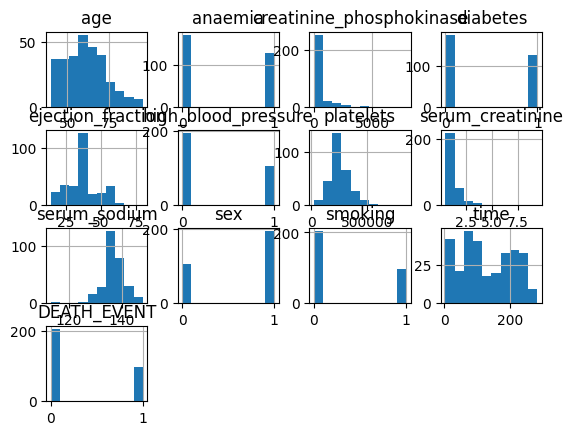

In [85]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist()

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [86]:
# Split into 80/20. 80% for cross validated training, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [87]:
# Separate input features from targets in all partitions

trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']

test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test.DEATH_EVENT

In [88]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc
def evaluate(model):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(trainval_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(trainval_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(trainval_targets, train_predictions)}')
    print(f'Training F1: {f1_score(trainval_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(trainval_targets, train_probabilities[:,1])}')
    
    # Evaluate and print the final test scores     

    test_probabilities = model.predict_proba(test_features)
    test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

    print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
    print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
    print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
    print(f'Test F1: {f1_score(test_targets, test_predictions)}')
    print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

In [89]:
# A custom function for returning the results for all metrics based on the best f1 score on test data
def show_cv_results(cv_results):
    sorted_results = cv_results.sort_values('rank_test_f1',ascending=True)
    return sorted_results[['mean_train_f1', 'mean_train_precision', 'mean_train_recall', 'mean_train_accuracy', 'mean_train_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc']].iloc[0]

In [90]:
# Define the metrics that we wan't to use. The names of available scorers can be accessed through
# get_scorer_names. The actual scorer objects are found using get_scorer
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [91]:
# Train a decision tree using grid search

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring=metrics, refit='f1',return_train_score=True)

dt_grid.fit(trainval_features, trainval_targets)

dt_cv_results = pd.DataFrame(dt_grid.cv_results_)
dt_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.001764,0.000309,0.008390,0.002861,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.812500,0.812500,0.895833,0.833333,0.808511,0.832535,0.032825,1,0.858639,0.853403,0.832461,0.848168,0.859375,0.850409,0.009841,0.800000,0.750000,0.866667,0.900000,0.750000,0.813333,0.060919,1,0.888889,0.826923,0.795918,0.796296,0.906977,0.843001,0.046594,0.533333,0.600000,0.8125,0.5625,0.600000,0.621667,0.098651,36,0.645161,0.693548,0.639344,0.704918,0.629032,0.662401,0.030725,0.640000,0.666667,0.838710,0.692308,0.666667,0.700870,0.070877,3,0.747664,0.754386,0.709091,0.747826,0.742857,0.740365,0.016061,0.736364,0.754545,0.875000,0.765625,0.753125,0.776932,0.049918,12,0.803201,0.811890,0.781211,0.810151,0.799132,0.801117,0.010975
1,0.001632,0.000107,0.008684,0.000510,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.812500,0.729167,0.895833,0.833333,0.744681,0.803103,0.060796,5,0.863874,0.869110,0.842932,0.848168,0.875000,0.859817,0.012281,0.800000,0.555556,0.923077,0.900000,0.571429,0.750012,0.157894,6,0.928571,0.760563,0.829787,0.796296,0.806452,0.824334,0.056688,0.533333,0.666667,0.7500,0.5625,0.800000,0.662500,0.103212,16,0.629032,0.870968,0.639344,0.704918,0.806452,0.730143,0.094614,0.640000,0.606061,0.827586,0.692308,0.666667,0.686524,0.076112,9,0.750000,0.812030,0.722222,0.747826,0.806452,0.767706,0.035336,0.787879,0.751515,0.865234,0.828125,0.806250,0.807801,0.038155,5,0.884909,0.900663,0.877932,0.880643,0.884988,0.885827,0.007885
2,0.002094,0.000507,0.007218,0.000402,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.833333,0.708333,0.895833,0.750000,0.744681,0.786436,0.068320,18,0.890052,0.905759,0.842932,0.905759,0.911458,0.891192,0.025161,0.818182,0.538462,0.923077,0.642857,0.578947,0.700305,0.146795,17,0.936170,0.879310,0.829787,0.890909,0.924528,0.892141,0.037528,0.600000,0.466667,0.7500,0.5625,0.733333,0.622500,0.106706,35,0.709677,0.822581,0.639344,0.803279,0.790323,0.753041,0.068639,0.692308,0.500000,0.827586,0.600000,0.647059,0.653391,0.107961,26,0.807339,0.850000,0.722222,0.844828,0.852174,0.815313,0.049320,0.827273,0.733333,0.873047,0.783203,0.834375,0.810246,0.047881,4,0.919542,0.925919,0.920933,0.942182,0.938524,0.929420,0.009248
3,0.001736,0.000107,0.008205,0.000590,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.791667,0.770833,0.833333,0.770833,0.744681,0.782270,0.029565,23,0.926702,0.937173,0.890052,0.942408,0.947917,0.928850,0.020623,0.727273,0.642857,0.785714,0.692308,0.571429,0.683916,0.073010,23,0.913793,0.946429,1.00

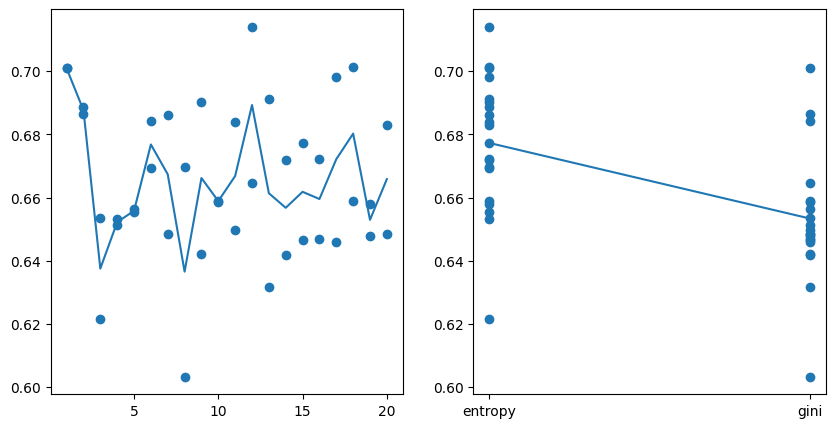

In [92]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
dt_param_scores = dt_cv_results[['param_max_depth', 'param_criterion', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average max_depth performance 
# accross the other parameter values
dt_max_depth = dt_param_scores.pivot_table(index='param_criterion', columns='param_max_depth', values='mean_test_f1')
dt_max_depth_means = dt_max_depth.mean(axis=0)

# A frame to find the average performance of each criteria value
dt_criterion = dt_param_scores.pivot_table(index='param_max_depth', columns='param_criterion', values='mean_test_f1')
dt_criterion_means = dt_criterion.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(dt_max_depth_means.index, dt_max_depth_means)
ax[0].scatter(dt_cv_results['param_max_depth'], dt_cv_results['mean_test_f1'])
ax[1].plot(dt_criterion_means.index, dt_criterion_means)
ax[1].scatter(dt_cv_results['param_criterion'], dt_cv_results['mean_test_f1'])
plt.show()


In [93]:
show_cv_results(dt_cv_results)

mean_train_f1           0.998374
mean_train_precision    0.996774
mean_train_recall       1.000000
mean_train_accuracy     0.998953
mean_train_roc_auc      0.999975
mean_test_f1            0.714025
mean_test_precision     0.746795
mean_test_recall        0.700833
mean_test_accuracy      0.815337
mean_test_roc_auc       0.785265
Name: 31, dtype: float64

In [94]:
evaluate(dt_grid)

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1: 1.0
Training ROC AUC: 1.0
Test Accuracy: 0.7166666666666667
Test Precision: 0.5454545454545454
Test Recall: 0.631578947368421
Test F1: 0.5853658536585366
Test ROC AUC: 0.6938382541720154



In [95]:
# Calculate the confusion matrix for the best decision tree model.

confusion_matrix(test_targets, dt_grid.predict(test_features))

array([[31, 10],
       [ 7, 12]])

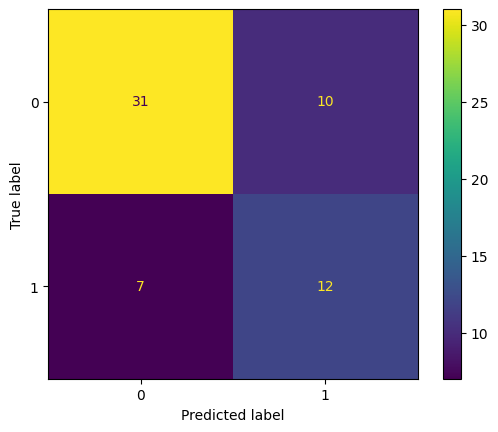

In [96]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots

ConfusionMatrixDisplay.from_estimator(dt_grid, test_features, test_targets)

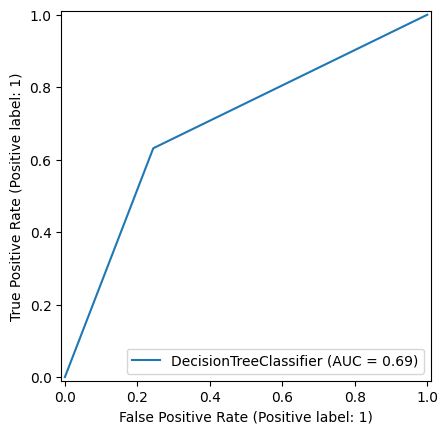

In [97]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt_grid.best_estimator_, test_features, test_targets)

The ROC curve show very good performance for all sensitivities. This is also shown by the AUC of 0.84

In [98]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6) # The values are specified with the exponents i.e. 1e-10, ..., 1e-5
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1', return_train_score=True)
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.002175,0.000803,0.008850,0.000933,0.0,{'var_smoothing': 1e-10},0.812500,0.729167,0.812500,0.770833,0.872340,0.799468,0.047775,3,0.827225,0.827225,0.795812,0.832461,0.833333,0.823211,0.013935,0.875000,0.625000,0.888889,0.727273,0.764706,0.776173,0.097824,4,0.822222,0.853659,0.805556,0.853659,0.875000,0.842019,0.024820,0.466667,0.333333,0.5000,0.5000,0.866667,0.533333,0.177639,3,0.596774,0.564516,0.475410,0.573770,0.564516,0.554997,0.041505,0.608696,0.434783,0.640000,0.592593,0.812500,0.617714,0.120511,3,0.691589,0.679612,0.597938,0.686275,0.686275,0.668338,0.035404,0.822222,0.848485,0.902344,0.816406,0.943750,0.866641,0.049085,1,0.900975,0.903351,0.888525,0.899369,0.902605,0.898965,0.005398
1,0.002161,0.000305,0.007857,0.000502,0.0,{'var_smoothing': 1e-09},0.791667,0.750000,0.833333,0.791667,0.851064,0.803546,0.035481,2,0.842932,0.837696,0.811518,0.837696,0.848958,0.835760,0.012812,0.857143,0.666667,0.900000,0.750000,0.750000,0.784762,0.083525,3,0.820000,0.878049,0.837838,0.875000,0.866667,0.855511,0.022740,0.400000,0.400000,0.5625,0.5625,0.800000,0.545000,0.146757,2,0.661290,0.580645,0.508197,0.573770,0.629032,0.590587,0.052243,0.545455,0.500000,0.692308,0.642857,0.774194,0.630963,0.098876,2,0.732143,0.699029,0.632653,0.693069,0.728972,0.697173,0.035825,0.812121,0.812121,0.902344,0.808594,0.950000,0.857036,0.058440,2,0.893723,0.898600,0.878436,0.886759,0.883499,0.888203,0.007186
2,0.001779,0.000178,0.007140,0.000214,0.0,{'var_smoothing': 1e-08},0.854167,0.791667,0.854167,0.750000,0.872340,0.824468,0.046211,1,0.842932,0.832461,0.811518,0.842932,0.848958,0.835760,0.013233,1.000000,0.777778,0.909091,0.750000,0.800000,0.847374,0.093459,1,0.820000,0.840909,0.857143,0.860465,0.866667,0.849037,0.016830,0.533333,0.466667,0.6250,0.3750,0.800000,0.560000,0.145239,1,0.661290,0.596774,0.491803,0.606557,0.629032,0.597091,0.057126,0.695652,0.583333,0.740741,0.500000,0.800000,0.663945,0.108434,1,0.732143,0.698113,0.625000,0.711538,0.728972,0.699153,0.039066,0.810101,0.787879,0.892578,0.812500,0.922917,0.845195,0.052672,3,0.876344,0.886597,0.859899,0.867844,0.860422,0.870221,0.010138
3,0.001680,0.000138,0.008854,0.000235,0.0,{'var_smoothing': 1e-07},0.833333,0.750000,0.791667,0.750000,0.787234,0.782447,0.030993,4,0.821990,0.821990,0.785340,0.811518,0.843750,0.816918,0.018962,1.000000,0.636364,0.875000,0.833333,0.692308,0.807401,0.130259,2,0.818182,0.868421,0.794118,0.820513,0.880952,0.836437,0.032810,0.466667,0.466667,0.4375,0.3125,0.600000,0.456667,0.

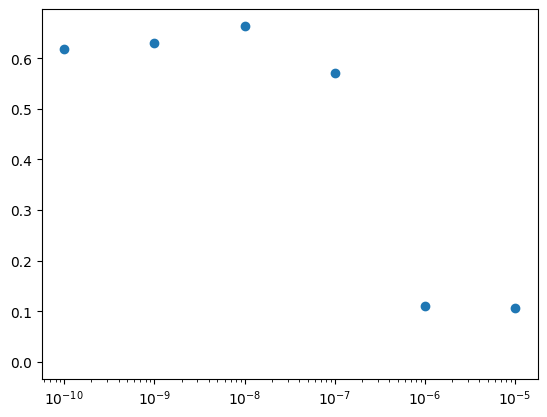

In [99]:
fig, ax = plt.subplots(1,1)
ax.semilogx(1e-10, 0)
plt.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

In [100]:
show_cv_results(nb_cv_results)

mean_train_f1           0.699153
mean_train_precision    0.849037
mean_train_recall       0.597091
mean_train_accuracy     0.835760
mean_train_roc_auc      0.870221
mean_test_f1            0.663945
mean_test_precision     0.847374
mean_test_recall        0.560000
mean_test_accuracy      0.824468
mean_test_roc_auc       0.845195
Name: 2, dtype: float64

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

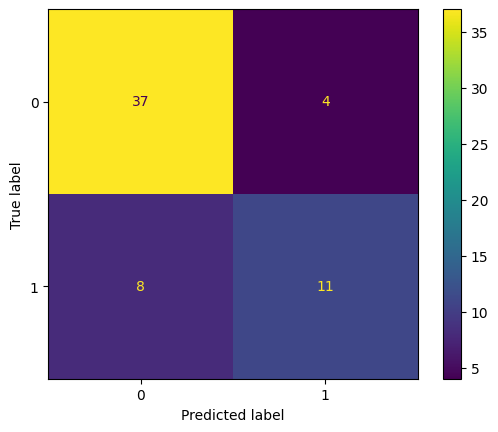

In [101]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

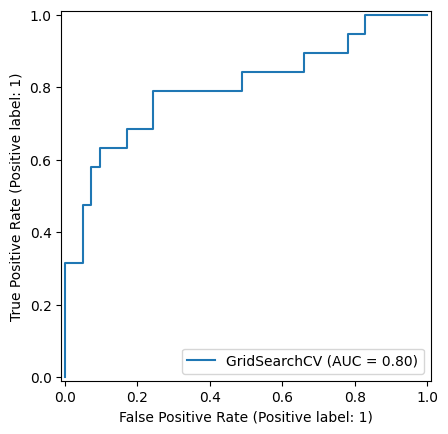

In [102]:
RocCurveDisplay.from_estimator(nb_grid, test_features, test_targets)

In [ ]:
# Train and evaluate a naive bayesian ensemble classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6) # The values are specified with the exponents i.e. 1e-10, ..., 1e-5
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1', return_train_score=True)
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

In [103]:
svc_params = {
    'C': [0.5, 1.0, 2.0, 4.0], 
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, scoring=metrics, refit='f1', return_train_score=True)
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
svc_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/sklearn/lib/py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.008774,0.001133,0.009534,0.001588,0.5,balanced,rbf,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.687500,0.666667,0.604167,0.562500,0.553191,0.614805,0.054073,14,0.664921,0.654450,0.659686,0.539267,0.682292,0.640123,0.051290,0.500000,0.400000,0.363636,0.368421,0.000000,0.326411,0.170437,3,0.450000,0.423077,0.437500,0.320000,0.516129,0.429341,0.063278,0.133333,0.133333,0.2500,0.4375,0.000000,0.190833,0.146544,12,0.145161,0.177419,0.229508,0.393443,0.258065,0.240719,0.085894,0.210526,0.200000,0.296296,0.400000,0.000000,0.221365,0.131986,8,0.219512,0.250000,0.301075,0.352941,0.344086,0.293523,0.051992,0.610101,0.446465,0.542969,0.550781,0.356250,0.501313,0.089520,10,0.543636,0.561515,0.532030,0.534174,0.584615,0.551194,0.019685
1,0.009734,0.003391,0.007867,0.000702,0.5,balanced,poly,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.312500,0.645833,0.645833,0.312500,0.659574,0.515248,0.165619,19,0.335079,0.670157,0.670157,0.329843,0.666667,0.534380,0.164880,0.312500,0.000000,0.333333,0.319149,0.000000,0.192996,0.157725,8,0.328042,0.400000,0.250000,0.322751,0.333333,0.326825,0.047575,1.000000,0.000000,0.0625,0.9375,0.000000,0.400000,0.465363,5,1.000000,0.032258,0.016393,1.000000,0.032258,0.416182,0.476721,0.476190,0.000000,0.105263,0.476190,0.000000,0.211529,0.219487,10,0.494024,0.059701,0.030769,0.488000,0.058824,0.226264,0.216425,0.375758,0.511111,0.519531,0.433594,0.370833,0.442165,0.063735,21,0.499625,0.532133,0.530013,0.488020,0.559057,0.521770,0.025279
2,0.012110,0.000412,0.009584,0.000584,0.5,balanced,sigmoid,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.395833,0.312500,0.666667,0.666667,0.553191,0.518972,0.143243,17,0.418848,0.361257,0.680628,0.680628,0.359375,0.500147,0.148905,0.266667,0.285714,0.000000,0.000000,0.400000,0.190476,0.162073,12,0.312977,0.307692,0.000000,0.000000,0.277372,0.179608,0.147152,0.533333,0.800000,0.0000,0.0000,0.800000,0.426667,0.361724,3,0.661290,0.774194,0.000000,0.000000,0.612903,0.409677,0.338571,0.355556,0.421053,0.000000,0.000000,0.533333,0.261988,0.221341,4,0.424870,0.440367,0.000000,0.000000,0.381910,0.249429,0.204557,0.375758,0.523232,0.441406,0.380859,0.654167,0.475084,0.104180,13,0.496874,0.463116,0.464817,0.499748,0.415509,0.468013,0.030433
3,0.006369,0.000395,0.008671,0.000912,0.5,None,rbf,"{'C': 0.5, 'class_weight': None, 'kernel': 'rbf'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825

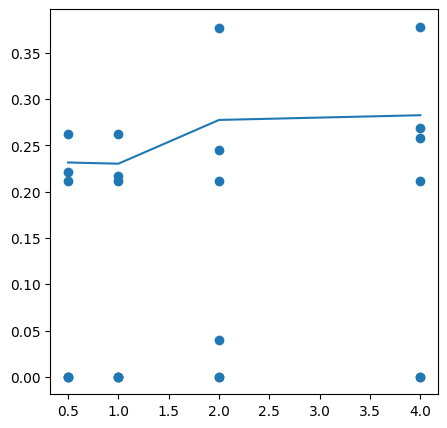

In [108]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned three parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
svc_param_scores = svc_cv_results[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average C performance 
# accross the other parameter values
svc_c = svc_param_scores.pivot_table(index=['param_class_weight','param_kernel'], columns='param_C', values='mean_test_f1')
svc_c_means = svc_c.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(svc_c_means.index, svc_c_means)
ax.scatter(svc_cv_results['param_C'], svc_cv_results['mean_test_f1'])
plt.show()


In [104]:
show_cv_results(svc_cv_results)

mean_train_f1           0.375516
mean_train_precision    0.300486
mean_train_recall       0.503014
mean_train_accuracy     0.465532
mean_train_roc_auc      0.457935
mean_test_f1            0.378308
mean_test_precision     0.303322
mean_test_recall        0.523333
mean_test_accuracy      0.452748
mean_test_roc_auc       0.468097
Name: 20, dtype: float64

In [105]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation metrics, but more evaluation 
# methods should be employed

evaluate(dt_grid.best_estimator_)
evaluate(nb_grid.best_estimator_)
evaluate(svc_grid.best_estimator_)

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1: 1.0
Training ROC AUC: 1.0
Test Accuracy: 0.7166666666666667
Test Precision: 0.5454545454545454
Test Recall: 0.631578947368421
Test F1: 0.5853658536585366
Test ROC AUC: 0.6938382541720154

Training Accuracy: 0.8368200836820083
Training Precision: 0.8392857142857143
Training Recall: 0.6103896103896104
Training F1: 0.706766917293233
Training ROC AUC: 0.8694885361552028
Test Accuracy: 0.8
Test Precision: 0.7333333333333333
Test Recall: 0.5789473684210527
Test F1: 0.6470588235294118
Test ROC AUC: 0.7997432605905006

Training Accuracy: 0.6736401673640168
Training Precision: 0.3333333333333333
Training Recall: 0.012987012987012988
Training F1: 0.025
Training ROC AUC: 0.542889209555876
Test Accuracy: 0.6833333333333333
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test ROC AUC: 0.3748395378690629



/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.